In [ ]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import gc
import shutil
import time
import random
import cv2
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import re

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

import torch
from numba import cuda

In [ ]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

list_sub = ["ccpd_base", "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]

BASE_PATH = "/content/CCPD2019/"

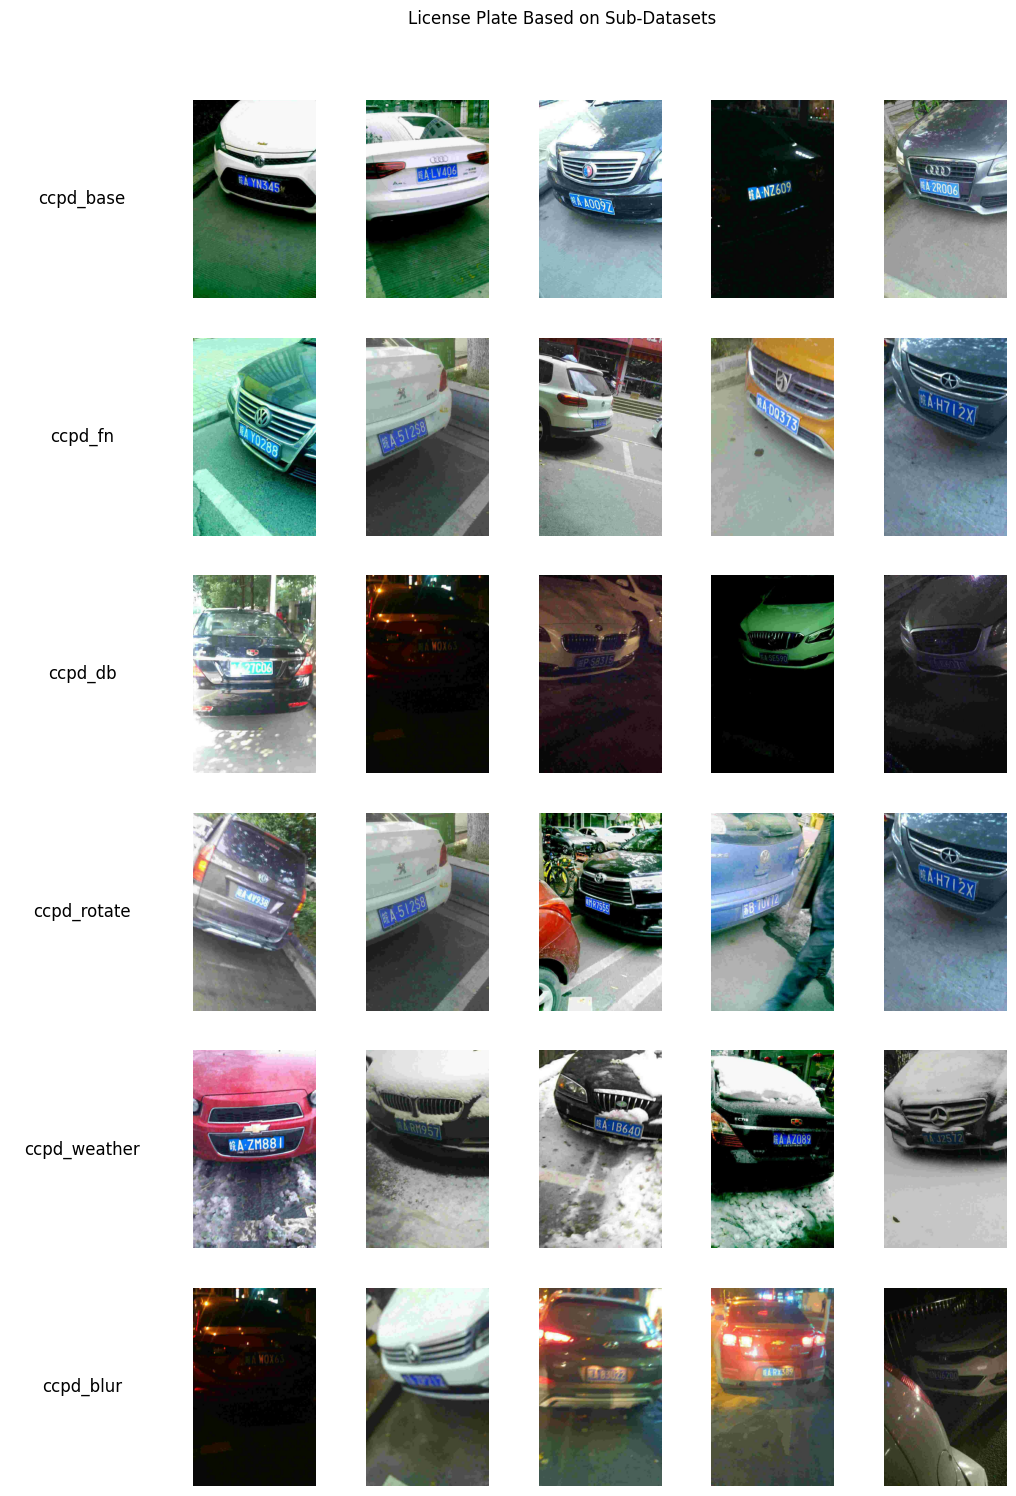

In [ ]:
# Sample Images

# Create Subplots
fig, axs = plt.subplots(6, 6, figsize=(13, 18))

# Plot the Data
for i, sub in enumerate(list_sub):
    axs[i, 0].text(0.5, 0.5, sub, ha='center', va='center', fontsize=12)
    axs[i, 0].axis('off')

    sub_path = os.path.join(BASE_PATH, sub)
    sub_files = os.listdir(sub_path)[:5]

    for j in range(5):
        file_name = os.path.join(sub_path, sub_files[j])
        image = cv2.imread(file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i, j+1].imshow(image)
        axs[i, j+1].axis("off")

# Title
plt.suptitle("License Plate Based on Sub-Datasets", x=0.55, y=0.93)

# Show
plt.show()

File Name: /content/CCPD2019/ccpd_base/0257734674329-99_72-267&439_515&551-519&564_257&508_254&420_516&476-0_0_22_12_27_28_29-87-37.jpg
Area Ratio: 0257734674329
Tilt Degrees
-  Horizontal: 99
-  Vertical  : 72
Bounding Box
-  Left-Up     : 267&439
-  Right-Bottom: 515&551
Vertices
-  Right-Bottom: 519&564
-  Left-Bottom : 257&508
-  Left-Up     : 254&420
-  Right-Up    : 516&476
License Plate Number: 皖A YN345
Brightness: 87
Blurriness: 37


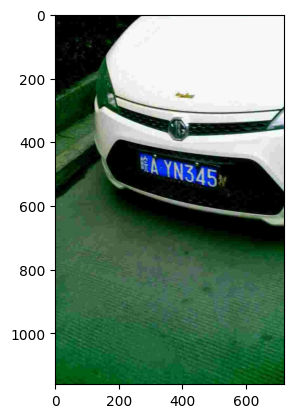

File Name: /content/CCPD2019/ccpd_base/0257734674329-85_94-296&374_544&469-544&451_309&485_303&398_538&364-0_0_10_19_28_24_30-89-28.jpg
Area Ratio: 0257734674329
Tilt Degrees
-  Horizontal: 85
-  Vertical  : 94
Bounding Box
-  Left-Up     : 296&374
-  Right-Bottom: 544&469
Vertices
-  Right-Bottom: 544&451
-  Left-Bottom : 309&485
-  Left-Up     : 303&398
-  Right-Up    : 538&364
License Plate Number: 皖A LV406
Brightness: 89
Blurriness: 28


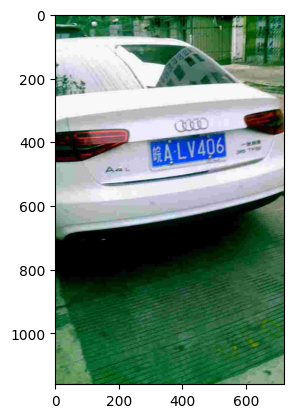

File Name: /content/CCPD2019/ccpd_base/0257734674329-98_73-189&545_439&663-450&679_190&630_168&538_428&587-0_0_0_24_24_33_23-139-83.jpg
Area Ratio: 0257734674329
Tilt Degrees
-  Horizontal: 98
-  Vertical  : 73
Bounding Box
-  Left-Up     : 189&545
-  Right-Bottom: 439&663
Vertices
-  Right-Bottom: 450&679
-  Left-Bottom : 190&630
-  Left-Up     : 168&538
-  Right-Up    : 428&587
License Plate Number: 皖A A009Z
Brightness: 139
Blurriness: 83


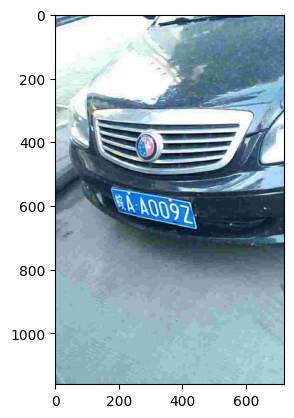

In [ ]:
# Image Description
ccpd_base_path = os.path.join(BASE_PATH, "ccpd_base")
ccpd_base_files = os.listdir(ccpd_base_path)
for file in ccpd_base_files[:3]:
    # File Name
    file_name = os.path.join(ccpd_base_path, file)
    file_splitting = file_name.split("/")[-1][:-4]
    file_splitting = file_splitting.split("-")
    print("File Name:", file_name)

    # Area Ratio
    area_ratio = file_splitting[0]
    print("Area Ratio:", area_ratio)

    # Tilt Degrees
    tilt_degrees = file_splitting[1]
    hor_tilt_degrees = tilt_degrees.split("_")[0]
    ver_tilt_degrees = tilt_degrees.split("_")[1]
    print("Tilt Degrees")
    print("-  Horizontal:", hor_tilt_degrees)
    print("-  Vertical  :", ver_tilt_degrees)

    # Bounding Box
    bounding_box = file_splitting[2]
    left_up_bbox = bounding_box.split("_")[0]
    right_bot_bbox = bounding_box.split("_")[1]
    print("Bounding Box")
    print("-  Left-Up     :", left_up_bbox)
    print("-  Right-Bottom:", right_bot_bbox)

    # Exact Vertices
    vertices = file_splitting[3]
    right_bot_vtc = vertices.split("_")[0]
    left_bot_vtc = vertices.split("_")[1]
    left_up_vtc = vertices.split("_")[2]
    right_up_vtc = vertices.split("_")[3]
    print("Vertices")
    print("-  Right-Bottom:", right_bot_vtc)
    print("-  Left-Bottom :", left_bot_vtc)
    print("-  Left-Up     :", left_up_vtc)
    print("-  Right-Up    :", right_up_vtc)

    # License Plate Numbers
    lcn = file_splitting[4]
    chi_let = provinces[int(lcn.split("_")[0])]
    alp_let = alphabets[int(lcn.split("_")[1])]
    alp_num_let = lcn.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + " " + alp_num_let
    print("License Plate Number:", all_let)

    # Brightness
    brightness = file_splitting[5]
    print("Brightness:", brightness)

    # Blurriness
    blurriness = file_splitting[6]
    print("Blurriness:", blurriness)

    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

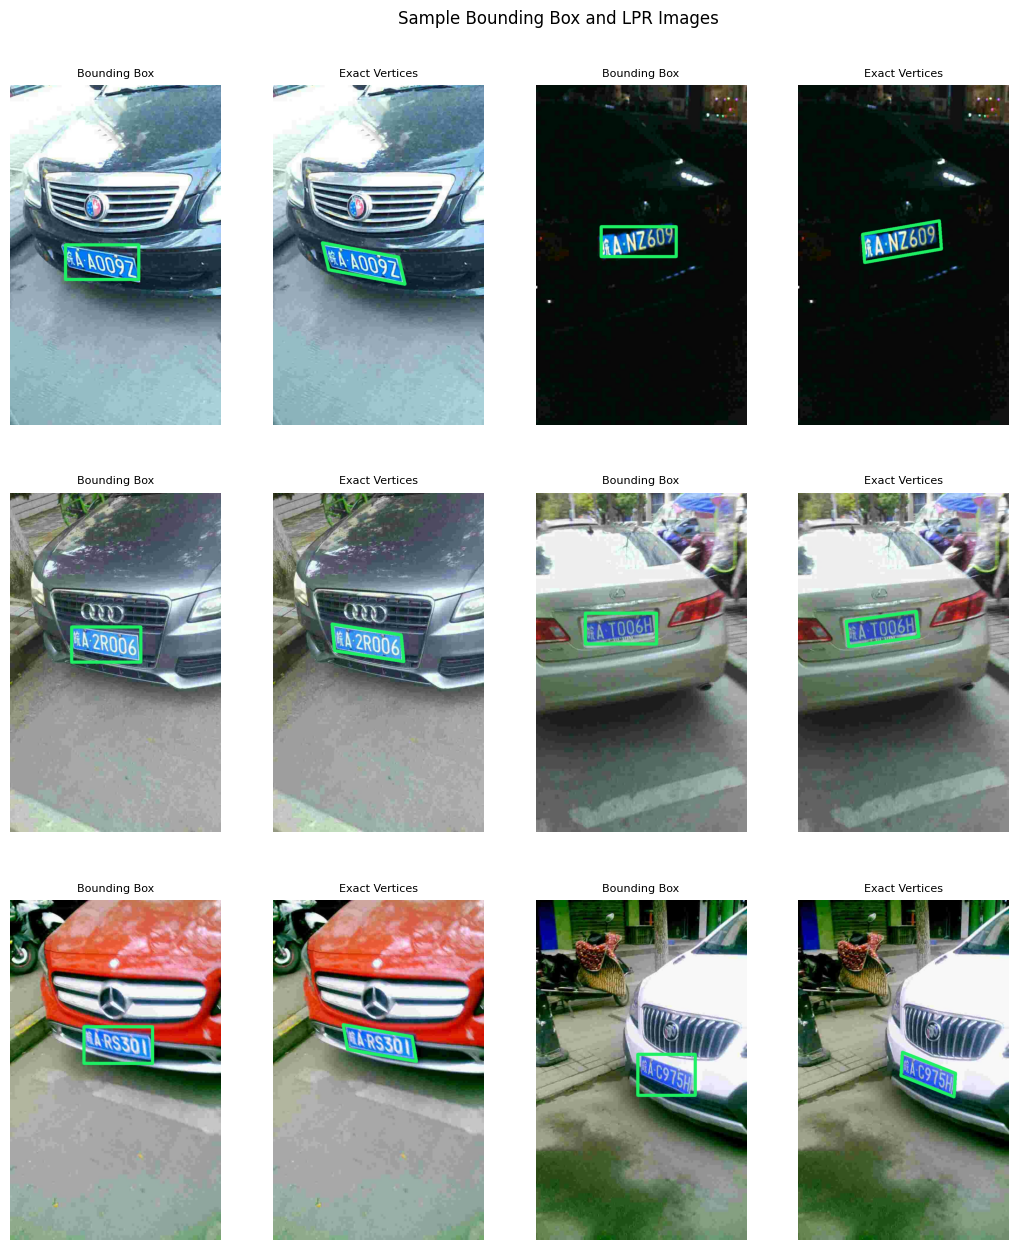

In [ ]:
# Sample Bounding Box and Exact Vertices

# Create Subplots
fig, axs = plt.subplots(3, 4, figsize=(13, 15))

# Plot the Data
for i, file in enumerate(ccpd_base_files[2:8]):
    # File Name
    file_name = os.path.join(ccpd_base_path, file)
    file_splitting = file_name.split("/")[-1][:-4]
    file_splitting = file_splitting.split("-")

    # License Plate Numbers
    lcn = file_splitting[4]
    chi_let = provinces[int(lcn.split("_")[0])]
    alp_let = alphabets[int(lcn.split("_")[1])]
    alp_num_let = lcn.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let

    # Bounding Box
    bounding_box = file_splitting[2]
    lu_bbox = bounding_box.split("_")[0]
    x1, y1 = list(map(int, lu_bbox.split("&")))
    rb_bbox = bounding_box.split("_")[1]
    x2, y2 = list(map(int, rb_bbox.split("&")))

    bbox_img = cv2.imread(file_name)
    bbox_img = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(bbox_img, (x1, y1), (x2, y2), (30, 240, 100), 10)
#     cv2.rectangle(bbox_img, (x1-50, y1-90), (x2+50, y1), (30, 240, 100), -1, 10)

#     # Add License Plate Number
#     textsize = cv2.getTextSize(all_let, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 4)[0]
#     textX = ((x2-x1+100) - textsize[0]) // 2
#     textY = (90 + textsize[1]) // 2

#     cv2.putText(bbox_img, all_let, (textX+x1-50, textY+y1-90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,0,0), 4)

    axs[i//2, (i*2)%4].imshow(bbox_img)
    axs[i//2, (i*2)%4].set_title("Bounding Box", fontsize=8)
    axs[i//2, (i*2)%4].axis("off")
    axs[i//2, (i*2)%4]

    # Exact Vertices
    vertices = file_splitting[3]
    vertices_split = vertices.split("_")

    exver_img = cv2.imread(file_name)
    exver_img = cv2.cvtColor(exver_img, cv2.COLOR_BGR2RGB)
    for j in range(4):
        x1, y1 = list(map(int, vertices_split[j].split("&")))
        x2, y2 = list(map(int, vertices_split[(j+1)%4].split("&")))
        cv2.line(exver_img, (x1, y1), (x2, y2), (30, 240, 100), thickness=10)

    axs[i//2, (i*2+1)%4].imshow(exver_img)
    axs[i//2, (i*2+1)%4].set_title("Exact Vertices", fontsize=8)
    axs[i//2, (i*2+1)%4].axis("off")
    axs[i//2, (i*2+1)%4]

# Title
plt.suptitle("Sample Bounding Box and LPR Images", x=0.55, y=0.93)

# Show
plt.show()

In [ ]:
# Create Metadata
def extract_plate_number(plate_number):
    chi_let = provinces[int(plate_number.split("_")[0])]
    alp_let = alphabets[int(plate_number.split("_")[1])]
    alp_num_let = plate_number.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let
    return all_let

df_metadata = pd.DataFrame()
for sub in list_sub:
    sub_path = os.path.join(BASE_PATH, sub, "*")
    sub_files = glob.glob(sub_path)

    df_metadata = df_metadata.append(sub_files)

df_metadata = df_metadata.rename(columns={0: "image_path"}).reset_index(drop=True)
df_metadata["sub"] = df_metadata["image_path"].apply(lambda x: x.split("/")[3])
print(df_metadata["sub"])
df_metadata["detail"] = df_metadata["image_path"].apply(lambda x: x.split("/")[4])
print(df_metadata["detail"])
df_metadata["bbox"] = df_metadata["detail"].apply(lambda x: x.split("-")[2])
df_metadata["x1_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[0].split("&")[0]))
df_metadata["y1_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[0].split("&")[1]))
df_metadata["x2_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[1].split("&")[0]))
df_metadata["y2_bbox"] = df_metadata["bbox"].apply(lambda x: int(x.split("_")[1].split("&")[1]))
df_metadata["plate_number"] = df_metadata["detail"].apply(lambda x: x.split("-")[4])
df_metadata["plate_number"] = df_metadata["plate_number"].apply(lambda x: extract_plate_number(x))

df_metadata = df_metadata.drop(["detail", "bbox"], axis=1)
df_metadata

0     ccpd_base
1     ccpd_base
2     ccpd_base
3     ccpd_base
4     ccpd_base
        ...    
73    ccpd_blur
74    ccpd_blur
75    ccpd_blur
76    ccpd_blur
77    ccpd_blur
Name: sub, Length: 78, dtype: object
0     0257734674329-99_72-267&439_515&551-519&564_25...
1     0257734674329-85_94-296&374_544&469-544&451_30...
2     0257734674329-98_73-189&545_439&663-450&679_19...
3     0257734674329-84_92-222&483_478&585-489&559_22...
4     0257734674329-96_79-210&460_446&580-446&578_21...
                            ...                        
73    01-2_3-306&477_450&535-450&535_307&528_306&477...
74    02-22_32-248&422_392&538-392&538_259&483_248&4...
75    03-1_1-332&441_593&537-589&537_332&532_336&441...
76    01-1_3-263&456_407&514-407&510_268&514_263&460...
77    02-3_2-234&503_426&590-418&590_234&579_242&503...
Name: detail, Length: 78, dtype: object


,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number
0,/content/CCPD2019/ccpd_base/0257734674329-99_7...,ccpd_base,267,439,515,551,皖AYN345
1,/content/CCPD2019/ccpd_base/0257734674329-85_9...,ccpd_base,296,374,544,469,皖ALV406
2,/content/CCPD2019/ccpd_base/0257734674329-98_7...,ccpd_base,189,545,439,663,皖AA009Z
3,/content/CCPD2019/ccpd_base/0257734674329-84_9...,ccpd_base,222,483,478,585,皖ANZ609
4,/content/CCPD2019/ccpd_base/0257734674329-96_7...,ccpd_base,210,460,446,580,皖A2R006
...,...,...,...,...,...,...,...
73,/content/CCPD2019/ccpd_blur/01-2_3-306&477_450...,ccpd_blur,306,477,450,535,皖AR865B
74,/content/CCPD2019/ccpd_blur/02-22_32-248&422_3...,ccpd_blur,248,422,392,538,皖AVT223
75,/content/CCPD2019/ccpd_blur/03-1_1-332&441_593...,ccpd_blur,332,441,593,537,皖AK8185
76,/content/CCPD2019/ccpd_blur/01-1_3-263&456_407...,ccpd_blur,263,456,407,514,皖ALZ849


In [ ]:
df_metadata['xmid'] = (df_metadata['x1_bbox'] + df_metadata['x2_bbox']) / (2*720)
df_metadata['ymid'] = (df_metadata['y1_bbox'] + df_metadata['y2_bbox']) / (2*1160)

df_metadata['bb_width'] = (df_metadata['x2_bbox'] - df_metadata['x1_bbox']) / 720
df_metadata['bb_height'] = (df_metadata['y2_bbox'] - df_metadata['y1_bbox']) / 1160

df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number,xmid,ymid,bb_width,bb_height
0,/content/CCPD2019/ccpd_base/0257734674329-99_7...,ccpd_base,267,439,515,551,皖AYN345,0.543056,0.426724,0.344444,0.096552
1,/content/CCPD2019/ccpd_base/0257734674329-85_9...,ccpd_base,296,374,544,469,皖ALV406,0.583333,0.363362,0.344444,0.081897
2,/content/CCPD2019/ccpd_base/0257734674329-98_7...,ccpd_base,189,545,439,663,皖AA009Z,0.436111,0.520690,0.347222,0.101724
3,/content/CCPD2019/ccpd_base/0257734674329-84_9...,ccpd_base,222,483,478,585,皖ANZ609,0.486111,0.460345,0.355556,0.087931
4,/content/CCPD2019/ccpd_base/0257734674329-96_7...,ccpd_base,210,460,446,580,皖A2R006,0.455556,0.448276,0.327778,0.103448
...,...,...,...,...,...,...,...,...,...,...,...
73,/content/CCPD2019/ccpd_blur/01-2_3-306&477_450...,ccpd_blur,306,477,450,535,皖AR865B,0.525000,0.436207,0.200000,0.050000
74,/content/CCPD2019/ccpd_blur/02-22_32-248&422_3...,ccpd_blur,248,422,392,538,皖AVT223,0.444444,0.413793,0.200000,0.100000
75,/content/CCPD2019/ccpd_blur/03-1_1-332&441_593...,ccpd_blur,332,441,593,537,皖AK8185,0.642361,0.421552,0.362500,0.082759
76,/content/CCPD2019/ccpd_blur/01-1_3-263&456_407...,ccpd_blur,263,456,407,514,皖ALZ849,0.465278,0.418103,0.200000,0.050000


In [ ]:
# Train : 5000 (ccpd_base), Val and Test : 50 for each sub (except ccpd_base)
list_split = ["train"] * 70
for i in range(2):
    list_split.extend(["val"]*2)
    list_split.extend(["test"]*2)
df_metadata["split"] = list_split
df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number,xmid,ymid,bb_width,bb_height,split
0,/content/CCPD2019/ccpd_base/0257734674329-99_7...,ccpd_base,267,439,515,551,皖AYN345,0.543056,0.426724,0.344444,0.096552,train
1,/content/CCPD2019/ccpd_base/0257734674329-85_9...,ccpd_base,296,374,544,469,皖ALV406,0.583333,0.363362,0.344444,0.081897,train
2,/content/CCPD2019/ccpd_base/0257734674329-98_7...,ccpd_base,189,545,439,663,皖AA009Z,0.436111,0.520690,0.347222,0.101724,train
3,/content/CCPD2019/ccpd_base/0257734674329-84_9...,ccpd_base,222,483,478,585,皖ANZ609,0.486111,0.460345,0.355556,0.087931,train
4,/content/CCPD2019/ccpd_base/0257734674329-96_7...,ccpd_base,210,460,446,580,皖A2R006,0.455556,0.448276,0.327778,0.103448,train
...,...,...,...,...,...,...,...,...,...,...,...,...
73,/content/CCPD2019/ccpd_blur/01-2_3-306&477_450...,ccpd_blur,306,477,450,535,皖AR865B,0.525000,0.436207,0.200000,0.050000,test
74,/content/CCPD2019/ccpd_blur/02-22_32-248&422_3...,ccpd_blur,248,422,392,538,皖AVT223,0.444444,0.413793,0.200000,0.100000,val
75,/content/CCPD2019/ccpd_blur/03-1_1-332&441_593...,ccpd_blur,332,441,593,537,皖AK8185,0.642361,0.421552,0.362500,0.082759,val
76,/content/CCPD2019/ccpd_blur/01-1_3-263&456_407...,ccpd_blur,263,456,407,514,皖ALZ849,0.465278,0.418103,0.200000,0.050000,test


In [ ]:
# Create Dataset Folder in YOLOv8
!mkdir "/content/datasets"
!mkdir "/content/datasets/train"
!mkdir "/content/datasets/val"
!mkdir "/content/datasets/test"


mkdir: cannot create directory ‘/content/datasets’: File exists


In [ ]:
def image_and_text_yolo(split):
    df = df_metadata[df_metadata["split"]==split].reset_index(drop=True)
    folder_path = os.path.join("/content/datasets", split)

    values = df[['image_path','xmid','ymid','bb_width','bb_height']].values
    for file_name, x, y, w, h in values:
        image_name = os.path.split(file_name)[-1]
        txt_name = os.path.splitext(image_name)[0]

        dst_image_path = os.path.join(folder_path, image_name)
        dst_label_file = os.path.join(folder_path, txt_name+'.txt')

        # copy each image into the folder
        shutil.copy(file_name, dst_image_path)

        # generate .txt which has label info
        label_txt = f'0 {x} {y} {w} {h}'
        with open(dst_label_file, mode='w') as f:
            f.write(label_txt)
            f.close()

image_and_text_yolo("train")
print("Train Dataset Created")
image_and_text_yolo("val")
print("Val Dataset Created")
image_and_text_yolo("test")
print("Test Dataset Created")

Train Dataset Created
Val Dataset Created
Test Dataset Created


In [ ]:
%%writefile /content/custom_dataset.yaml
# Create Custom Dataset Configuration
train: /kaggle/working/ultralytics/datasets/train
val: /kaggle/working/ultralytics/datasets/val
test: /kaggle/working/ultralytics/datasets/test

nc: 1

names: [
    'license_plate'
]

Writing /content/custom_dataset.yaml


In [ ]:
!yolo train model=yolov8s.pt data="/content/custom_dataset.yaml" epochs=25 verbose=True batch=32

/bin/bash: line 1: yolo: command not found


In [ ]:
training_results = pd.read_csv("/content/results.csv")
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

training_results

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.12560,1.05930,1.0773,0.96988,0.90265,0.96138,0.56851,1.3852,0.65026,1.3254,0.070191,0.003312,0.003312
1,1,1.05990,0.52001,1.0398,0.98272,0.96018,0.98374,0.62505,1.2426,0.51544,1.2303,0.039928,0.006382,0.006382
2,2,1.07900,0.55111,1.0545,0.97039,0.87007,0.94548,0.55503,1.4351,0.74472,1.3813,0.009401,0.009189,0.009189
3,3,1.08400,0.54510,1.0757,0.96612,0.88327,0.93844,0.60486,1.2810,0.63383,1.3417,0.008812,0.008812,0.008812
4,4,1.06830,0.51134,1.0754,0.92991,0.95575,0.97819,0.59461,1.3460,0.59867,1.3608,0.008812,0.008812,0.008812
5,5,1.05250,0.49296,1.0707,0.95647,0.97345,0.98135,0.62120,1.2627,0.53681,1.3316,0.008416,0.008416,0.008416
6,6,1.03410,0.47722,1.0612,0.94918,0.94690,0.96651,0.59786,1.3414,0.56983,1.3836,0.008020,0.008020,0.008020
7,7,1.02480,0.46405,1.0529,0.95026,0.88938,0.95174,0.61370,1.3157,0.59557,1.3799,0.007624,0.007624,0.007624
8,8,1.01770,0.45456,1.0502,0.93269,0.95575,0.97629,0.66971,1.2092,0.49951,1.2878,0.007228,0.007228,0.007228
9,9,1.00550,0.44181,1.0505,0.96937,0.97788,0.98412,0.64751,1.2393,0.50236,1.3318,0.006832,0.006832,0.006832


In [ ]:
# Training and Validation Loss

# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss", "Distributional Focal Loss"],
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

loss_list = ["box_loss", "cls_loss", "dfl_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss", "DFL Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [ ]:
# Validation Metrics

# Create Subplot
subplot_titles = ["Precision", "Recall", "mAP50", "mAP50-95"]
fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=subplot_titles,
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

metrics = ["precision", "recall", "mAP50", "mAP50-95"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )

    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=600,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [ ]:
!pip install ultralytics


In [ ]:
!yolo val model="/content/weights/best.pt" data="/content/custom_dataset.yaml" split="test"

Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
100% 755k/755k [00:00<00:00, 26.5MB/s]
val: Scanning /content/datasets/test... 4 images, 0 backgrounds, 0 corrupt: 100% 4/4 [00:00<00:00, 917.94it/s]
val: New cache created: /content/datasets/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:01<00:00,  1.88s/it]
                   all          4          4          1          1      0.995      0.735
Speed: 7.2ms preprocess, 431.3ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
os.listdir("/kaggle/working/runs/detect/val")

In [ ]:
df_results = df_metadata[df_metadata["split"]=="test"].reset_index(drop=True)
df_results = df_results[["image_path", "sub", "plate_number", "x1_bbox", "y1_bbox", "x2_bbox", "y2_bbox"]]
df_results

,image_path,sub,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,/content/CCPD2019/ccpd_blur/02-4_11-250&466_44...,ccpd_blur,皖NQ6200,250,466,442,553
1,/content/CCPD2019/ccpd_blur/01-2_3-306&477_450...,ccpd_blur,皖AR865B,306,477,450,535
2,/content/CCPD2019/ccpd_blur/01-1_3-263&456_407...,ccpd_blur,皖ALZ849,263,456,407,514
3,/content/CCPD2019/ccpd_blur/02-3_2-234&503_426...,ccpd_blur,皖AB6335,234,503,426,590


In [ ]:
# Get Bounding Box Predictions
from ultralytics import YOLO

yolo_model = YOLO('/content/weights/best.pt')
bbox_results = yolo_model.predict(list(df_results["image_path"]), verbose=False)
all_box_list = []
all_conf_list = []
for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []
    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)
        if(conf>=0.5):
            box_list.append(box_data)
            conf_list.append(conf)

    all_box_list.append(box_list)
    all_conf_list.append(conf_list)

In [ ]:
df_results["pred_bbox"] = all_box_list
df_results["confidence"] = all_conf_list
df_results

,image_path,sub,plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence
0,/content/CCPD2019/ccpd_blur/02-4_11-250&466_44...,ccpd_blur,皖NQ6200,250,466,442,553,"[[253, 480, 437, 539]]",[0.6]
1,/content/CCPD2019/ccpd_blur/01-2_3-306&477_450...,ccpd_blur,皖AR865B,306,477,450,535,"[[302, 478, 448, 534]]",[0.82]
2,/content/CCPD2019/ccpd_blur/01-1_3-263&456_407...,ccpd_blur,皖ALZ849,263,456,407,514,"[[266, 455, 401, 508]]",[0.77]
3,/content/CCPD2019/ccpd_blur/02-3_2-234&503_426...,ccpd_blur,皖AB6335,234,503,426,590,"[[234, 507, 418, 585]]",[0.85]


/content/CCPD2019/ccpd_blur/02-4_11-250&466_442&553-442&553_259&539_250&466_433&480-0_12_14_30_26_24_24-38-3.jpg


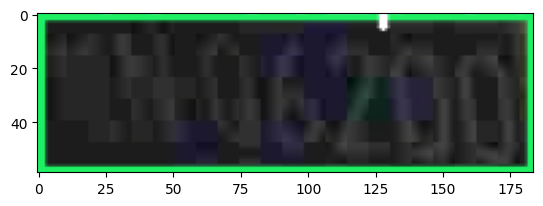

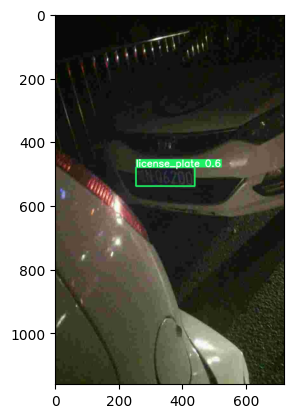

/content/CCPD2019/ccpd_blur/01-2_3-306&477_450&535-450&535_307&528_306&477_449&484-0_0_15_32_30_29_1-131-4.jpg


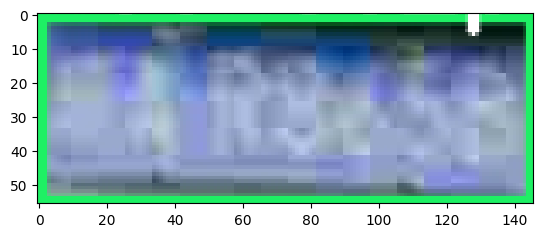

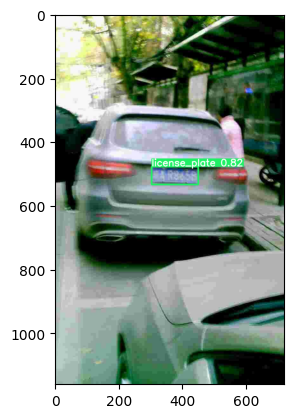

/content/CCPD2019/ccpd_blur/01-1_3-263&456_407&514-407&510_268&514_263&460_402&456-0_0_10_23_32_28_33-166-2.jpg


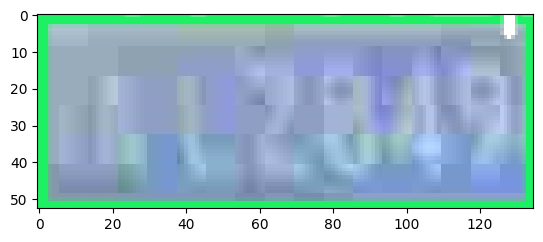

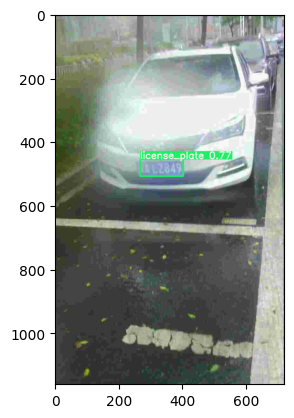

/content/CCPD2019/ccpd_blur/02-3_2-234&503_426&590-418&590_234&579_242&503_426&514-0_0_1_30_27_27_29-157-5.jpg


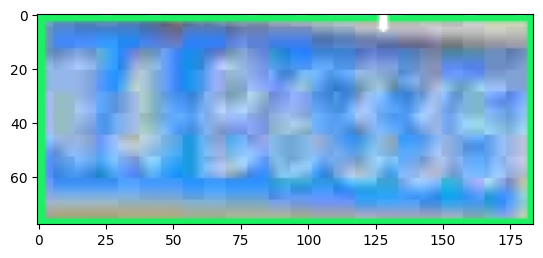

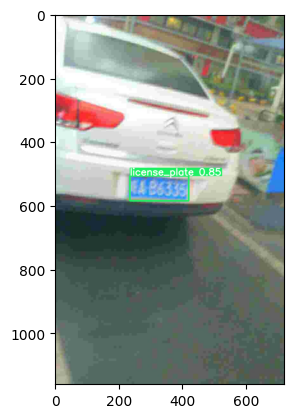

In [ ]:
%matplotlib inline
from ultralytics.utils.plotting import Annotator

def show_plate_detection(idx):
    # Original Image
    ori_path = df_results["image_path"][idx]
    print(ori_path)
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    # Annotate Box
    annotator = Annotator(ori_image)
    boxes = df_results["pred_bbox"][idx]
    confs = df_results["confidence"][idx]
    for i, box in enumerate(boxes):
        annotator.box_label(box=box, label="license_plate " + (str(confs[i])), color=(30, 240, 100))

        # Get Plate Object
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        roi = ori_image[y1:y2, x1:x2]
        plt.imshow(roi)
        plt.show()

    # Show Image
    frame = annotator.result()
    plt.imshow(frame)
    plt.show()

idxs = [0, 1,2,3]
for idx in idxs:
    show_plate_detection(idx)

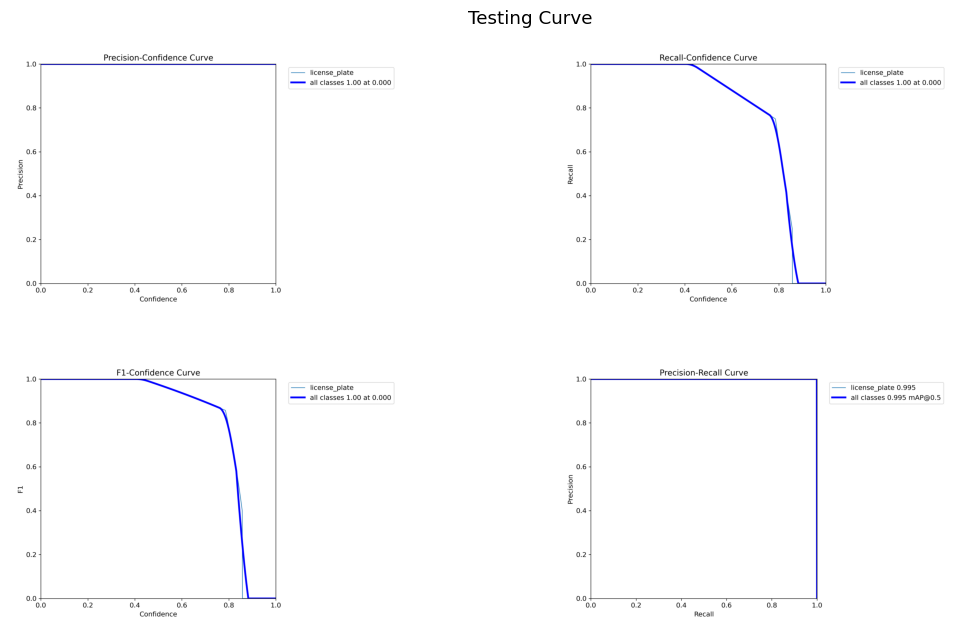

In [ ]:
# Testing Curve
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "/content/runs/detect/val2/{}.png".format(curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')

# Title
plt.suptitle("Testing Curve", x=0.55, y=0.93)

# Show
plt.show()